License
===

Copyright (c) 2017 Jeff Alstott

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

Except as contained in this notice, the name of the authors shall not be used
in advertising or otherwise to promote the sale, use or other dealings in this
Software without prior written authorization from the authors.

Initial setup
===

In [1]:
### Initial setup
%pylab inline
import pandas as pd
import seaborn as sns
sns.set_color_codes()
from matplotlib import rc
# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
rc('font',**{'family':'serif','serif':['DejaVu Sans']})
# rc('text', usetex=True)

Populating the interactive namespace from numpy and matplotlib


In [2]:
from pystan_time_series import TimeSeriesModel

Stan settings and testing functions
===

In [3]:
### Stan settings and testing functions
n_jobs = 4
n_iterations = 500

from scipy.stats import percentileofscore

def parameter_within_95(model_fit, parameter, parameter_stan, ind=None):
    parameter_samples = model_fit[parameter_stan]
    if ind is not None:
        parameter = parameter[ind]
        parameter_samples = parameter_samples[:,:,ind]
    parameter_samples = parameter_samples.squeeze()
    if parameter_samples.ndim==1:
        parameter_samples = atleast_2d(parameter_samples).T
    if shape(parameter) == ():
        parameter = array([parameter for i in range(parameter_samples.shape[1])])
    else:
        parameter = array(parameter)
        
    if parameter_samples.ndim>2:
            parameter_samples = parameter_samples.reshape(parameter_samples.shape[0], 
                                                          prod(parameter_samples.shape[1:]))
    true_parameters_inferred_scores = array(list(map(percentileofscore, 
                                                     parameter_samples.T, 
                                                     parameter.ravel())))
    true_parameters_inferred_score_within_95CI = ((true_parameters_inferred_scores>=2.5) & 
                                                  (true_parameters_inferred_scores<=97.5)
                                                 )

    return true_parameters_inferred_score_within_95CI

def plot_time_series_inference(model_fit, var='Y_latent', x=None,
                               ax=None, ind=0, D=1, **kwargs):
    from scipy.stats import scoreatpercentile
    ci_thresholds = [2.5, 25, 50, 75, 97.5]
    
    data = model_fit[var].squeeze()
    
    if data.ndim==3:
        data = data[:,ind,:]
    elif data.ndim>3:
        data = data[:,ind,:,D]
        
    CIs = scoreatpercentile(data, ci_thresholds, axis=0)
    CIs = pd.DataFrame(data=CIs.T, columns=ci_thresholds)
    if ax is None:
        ax=gca()
    if x is None:
        x = arange(data.shape[1])
    ax.fill_between(x, CIs[2.5], CIs[97.5],alpha=.5, **kwargs)
    ax.fill_between(x, CIs[25], CIs[75], **kwargs)
    ax.plot(x, CIs[50], **kwargs)
    

def check_div(fit, parameters):
    div = concatenate([s['divergent__'] for s in fit.get_sampler_params(inc_warmup=False)]).astype('bool')

    if sum(div==0):
        print("\x1b[32m\"No divergences\"\x1b[0m")
    else:
        ###ndtest from https://github.com/syrte/ndtest
        from ndtest import ks2d2s
        divergences = {}
        non_divergences = {}
        for parameter in parameters:
            divergences[parameter] = fit[parameter][div].squeeze()
            non_divergences[parameter] = fit[parameter][~div].squeeze()
            if divergences[parameter].ndim>2:
                N = divergences[parameter].shape[3]
                for n in arange(N):
                    divergences[parameter+'.%i'%n] = divergences[parameter][:,:,n]
                    non_divergences[parameter+'.%i'%n] = non_divergences[parameter][:,:,n]
                del divergences[parameter]
                del non_divergences[parameter]

            any_unevenly_distributed = False
            
            for k1 in divergences.keys():
                for k2 in divergences.keys():
                    if k1==k2:
                        continue

                    x = divergences[k1].ravel()
                    y = divergences[k2].ravel()

                    x_non = non_divergences[k1].ravel()
                    y_non = non_divergences[k2].ravel()

                    p = ks2d2s(x_non, y_non, x, y)
                    if p<.05:
                        any_unevenly_distributed = True
                        figure()
                        scatter(x_non, y_non,
                           alpha=.1, label='Non-Divergent')
                        scatter(x,y,
                               alpha=1, label='Divergent')
                        xlabel(k1)
                        ylabel(k2)
                        legend()
                        title("KS test p=%.2f"%(p))
        if any_unevenly_distributed:
            print("\x1b[31m\"%.2f divergences, which appear to be non-spurious\"\x1b[0m"%(div.mean()))
        else:
            print("\x1b[32m\"%.2f divergences, which appear to be spurious\"\x1b[0m"%(div.mean()))

from pystan.misc import _summary
import stan_utility
def test_model_fit(fit, parameters, max_depth=10):
    if type(parameters[0])==tuple:
        fit_params = []
        for data_param, fit_param in parameters:
            print(fit_param)
            if hasattr(data_param, '__len__') and len(data_param)!=fit[fit_param].shape[1]:
                inds = len(data_param)
                within_95 = 0.0
                for i in range(inds):
                    within_95 += parameter_within_95(fit, data_param, fit_param, ind=i)
                within_95 /= inds
            else:
                within_95 = parameter_within_95(fit, data_param, fit_param)
            if within_95.mean()>.9:
                c = '32'
            else:
                c = '31'
            print("\x1b[%sm\"%.0f%% of values recovered\"\x1b[0m"%(c, within_95.mean()*100))

            Rhats = _summary(fit, pars=fit_param)['summary'][:,-1]
            if all(abs(Rhats-1)<.1):
                c = '32'
            else:
                c = '31'
            print("\x1b[%sm\"Maximum Rhat of %.2f\"\x1b[0m"%(c,max(Rhats)))
            fit_params.append(fit_param)
    stan_utility.check_treedepth(fit,max_depth=max_depth)
    stan_utility.check_energy(fit)
    check_div(fit, fit_param)
            
from time import time

def plot_distribution(data, **kwargs):
    from scipy.stats import scoreatpercentile
    from bisect import bisect_left

    p = sns.kdeplot(data, **kwargs)
    p = p.get_lines()[-1]
    x,y = p.get_data()
    c = p.get_color()
    lower = scoreatpercentile(data, 2.5)
    upper = scoreatpercentile(data, 97.5)
    lower_ind = bisect_left(x,lower)
    upper_ind = bisect_left(x,upper) 
    fill_between(x[lower_ind:upper_ind], y[lower_ind:upper_ind], alpha=.4, color=c)
    return

ARMA model
===

Normally distributed shocks around a constant level
---
$\epsilon_t \sim normal(0, \sigma)$

$Y_t \sim \mu + \epsilon_t$

Priors:
- $\mu \sim normal(0,4)$
- $\sigma \sim cauchy(0,4)$

Fitting took 0.19 minutes
mu
"100% of values recovered"
"Maximum Rhat of 1.00"
sigma
"100% of values recovered"
"Maximum Rhat of 1.00"
"0 of 1000 iterations saturated the maximum tree depth of 15 (0.0%)"
"Chain 0: E-BFMI = 0.9907714044994919"
"Chain 1: E-BFMI = 1.0947297837531005"
"Chain 2: E-BFMI = 0.9712398586054284"
"Chain 3: E-BFMI = 0.8518384514050203"
"No divergences"


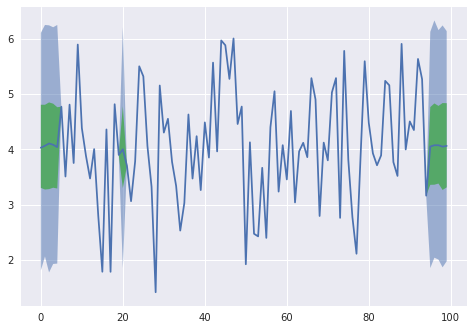

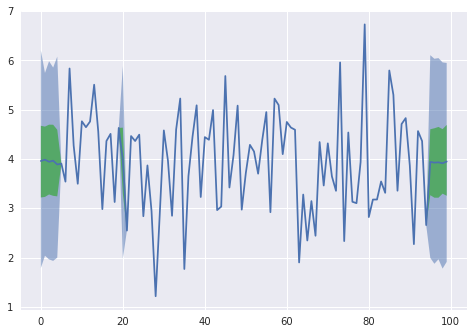

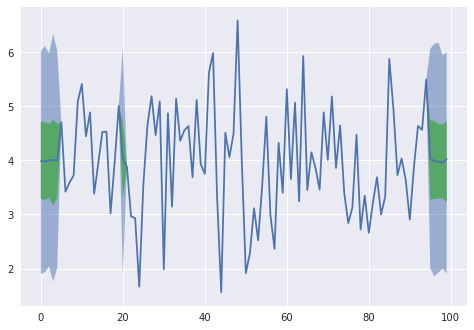

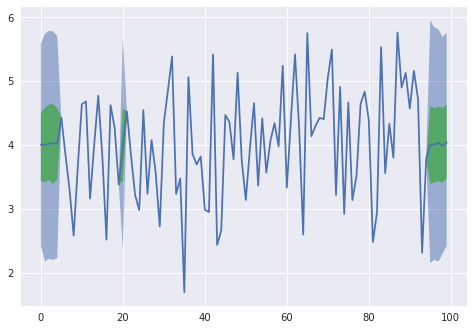

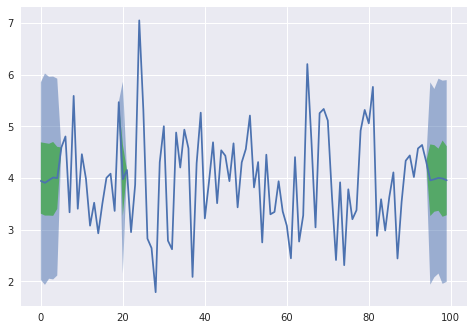

In [4]:
### Simply noise
n = 20
t = 100
sigma = 1
mu = 4

Y = (randn(t,n)*sigma)+mu

Y[:5] = nan #Some data is missing. We can model it!
Y[20] = nan
Y[-5:] = nan

model = TimeSeriesModel(Y=Y)
start_time = time()
max_depth = 15
model.sampling(n_jobs=n_jobs, iter=n_iterations, control={'max_treedepth':max_depth})
finish_time = time()
print("Fitting took %.2f minutes"%((finish_time-start_time)/60))

parameter_pairs = [(mu, 'mu'), (sigma, 'sigma')]
test_model_fit(model.fit, parameter_pairs, max_depth=max_depth)

# print(model.fit)

for i in range(min(5,n)):
    figure()
    plot_time_series_inference(model.fit, ind=i)

Show priors and how they update to posteriors

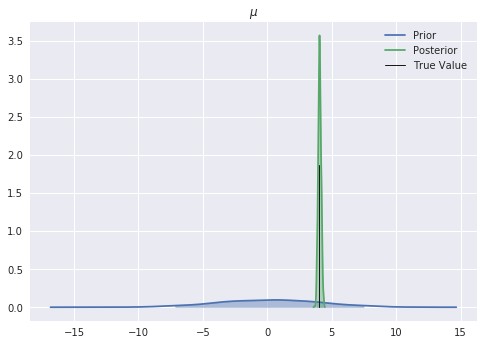

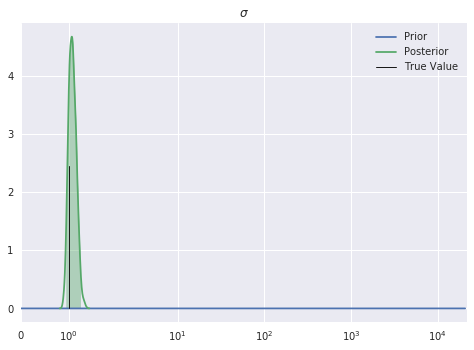

In [5]:
### Show priors and how they update to posteriors
model_priors = TimeSeriesModel(Y=Y, return_priors=True)
start_time = time()
model_priors.sampling(n_jobs=n_jobs, iter=n_iterations)
finish_time = time()

plot_distribution(model_priors.fit['mu'][:,0,0], label='Prior')
plot_distribution(model.fit['mu'][:,0,0], label='Posterior')
plot((mu,mu), (0,ylim()[1]*.5), 'k', label='True Value', linewidth=1)
legend()
title(r"$\mu$")

figure()
plot_distribution(model_priors.fit['sigma'][:,0,0], label='Prior')
plot_distribution(model.fit['sigma'][:,0,0], label='Posterior')
plot((sigma,sigma), (0,ylim()[1]*.5), 'k', label='True Value', linewidth=1)
xlim(xmin=0)
xscale('symlog')
legend()
title(r"$\sigma$")

Add an autoregressive component
---
(An AR(1) model)

$\epsilon_t \sim normal(0, \sigma)$

$Y_t \sim \mu + \epsilon_t + \phi_1 Y_{t-1}$

Priors:
- $\mu \sim normal(0,4)$
- $\sigma \sim cauchy(0,4)$
- $\phi \sim normal(0,4)$

Fitting took 0.58 minutes
mu
"100% of values recovered"
"Maximum Rhat of 1.01"
sigma
"90% of values recovered"
"Maximum Rhat of 1.00"
phi
"95% of values recovered"
"Maximum Rhat of 1.01"
"0 of 1000 iterations saturated the maximum tree depth of 10 (0.0%)"
"Chain 0: E-BFMI = 0.9109454724280832"
"Chain 1: E-BFMI = 1.0474012336227059"
"Chain 2: E-BFMI = 0.9453650758581355"
"Chain 3: E-BFMI = 0.9529980587294671"
"No divergences"


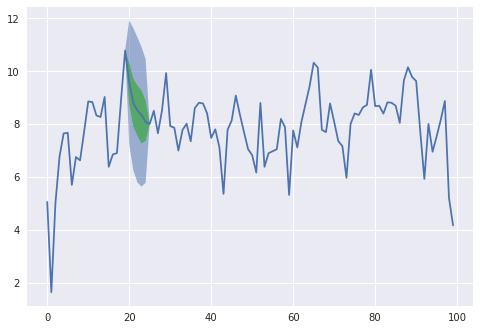

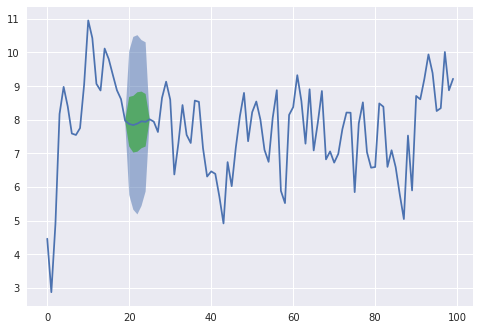

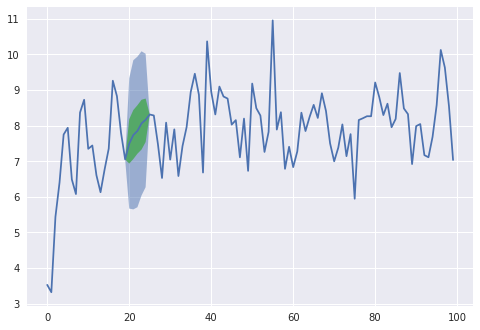

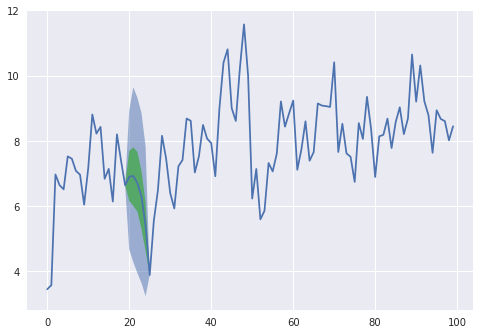

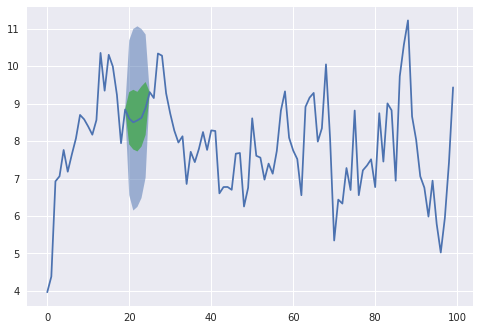

In [6]:
phi = array([.5])
p = len(phi)

Y = (randn(t,n)*sigma)+mu
for i in range(1+p,t):
    Y[i] += dot(phi,Y[i-p:i])

Y[20:25] = nan

model = TimeSeriesModel(Y=Y, p=p)
start_time = time()
model.sampling(n_jobs=n_jobs, iter=n_iterations)
finish_time = time()
print("Fitting took %.2f minutes"%((finish_time-start_time)/60))

parameter_pairs = [(mu, 'mu'), (sigma, 'sigma'), (phi, 'phi')]
test_model_fit(model.fit, parameter_pairs)

# print(model.fit)

for i in range(min(5,n)):
    figure()
    plot_time_series_inference(model.fit, ind=i)

Add a second-order autoregressive component
---
(An AR(2) model)

$\epsilon_t \sim normal(0, \sigma)$

$Y_t \sim \mu + \epsilon_t + \phi_1 Y_{t-1} + \phi_2 Y_{t-2}$

Priors:
- $\mu \sim normal(0,4)$
- $\sigma \sim cauchy(0,4)$
- $\phi \sim normal(0,4)$

Fitting took 0.68 minutes
mu
"95% of values recovered"
"Maximum Rhat of 1.00"
sigma
"100% of values recovered"
"Maximum Rhat of 1.00"
phi
"92% of values recovered"
"Maximum Rhat of 1.00"
"0 of 1000 iterations saturated the maximum tree depth of 10 (0.0%)"
"Chain 0: E-BFMI = 0.9288329998582862"
"Chain 1: E-BFMI = 0.8918935749525493"
"Chain 2: E-BFMI = 0.9350901716124171"
"Chain 3: E-BFMI = 1.0417104776151584"
"No divergences"


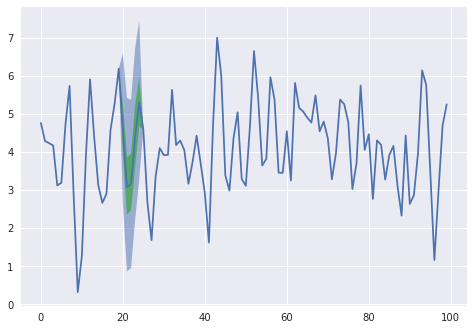

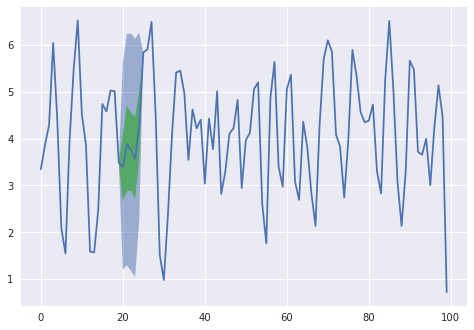

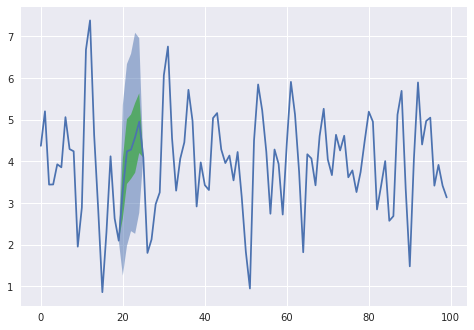

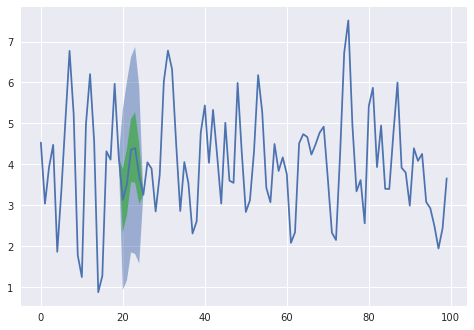

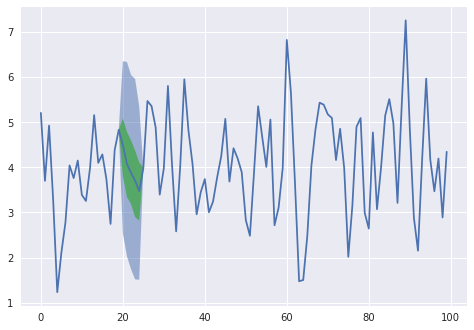

In [7]:
phi = array([.5, -.5])
p = len(phi)

Y = (randn(t,n)*sigma)+mu
for i in range(1+p,t):
    Y[i] += dot(phi[::-1],Y[i-p:i])

Y[20:25] = nan

model = TimeSeriesModel(Y=Y, p=p)
start_time = time()
model.sampling(n_jobs=n_jobs, iter=n_iterations)
finish_time = time()
print("Fitting took %.2f minutes"%((finish_time-start_time)/60))

parameter_pairs = [(mu, 'mu'), (sigma, 'sigma'), (phi, 'phi')]
test_model_fit(model.fit, parameter_pairs)

# print(model.fit)

for i in range(min(5,n)):
    figure()
    plot_time_series_inference(model.fit, ind=i)

Normally distributed shocks, with a moving average component
---
(An MA(1) model)

$\epsilon_t \sim normal(0, \sigma)$

$Y_t \sim \mu + \epsilon_t + \theta \epsilon_{t-1}$

Priors:
- $\mu \sim normal(0,4)$
- $\sigma \sim cauchy(0,4)$
- $\theta \sim normal(0,4)$

Fitting took 0.47 minutes
mu
"90% of values recovered"
"Maximum Rhat of 1.00"
sigma
"95% of values recovered"
"Maximum Rhat of 1.00"
theta
"95% of values recovered"
"Maximum Rhat of 1.00"
"0 of 1000 iterations saturated the maximum tree depth of 10 (0.0%)"
"Chain 0: E-BFMI = 0.8214363602553817"
"Chain 1: E-BFMI = 1.079373184067513"
"Chain 2: E-BFMI = 0.9034720927853059"
"Chain 3: E-BFMI = 0.8583146450408913"
"No divergences"


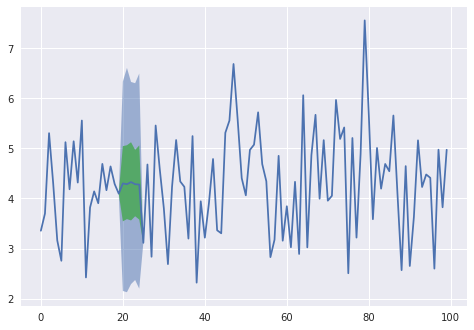

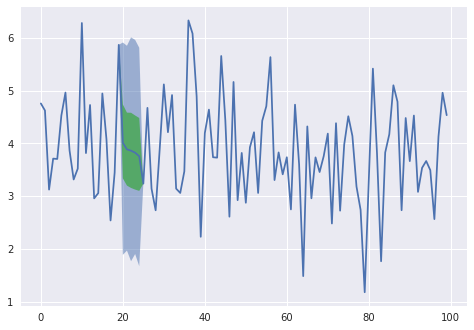

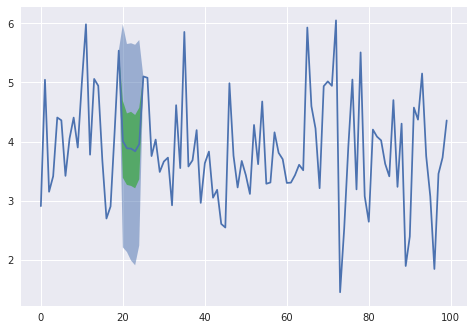

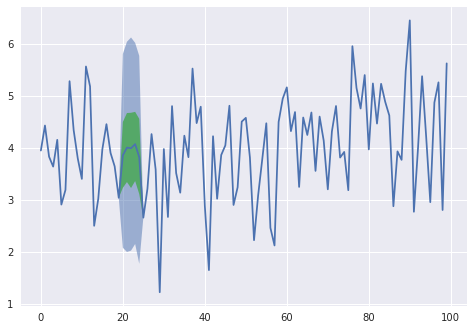

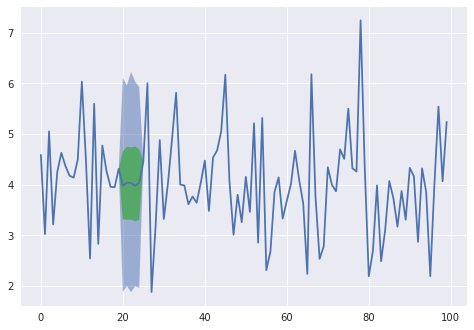

In [8]:
theta = array([.1])
q = len(theta)

errs = (randn(t,n)*sigma)
Y = mu+errs
for i in range(1+q,t):
    Y[i] += dot(theta[::-1],errs[i-q:i])

Y[20:25] = nan


model = TimeSeriesModel(Y=Y, q=q)
start_time = time()
model.sampling(n_jobs=n_jobs, iter=n_iterations)
finish_time = time()
print("Fitting took %.2f minutes"%((finish_time-start_time)/60))

parameter_pairs = [(mu, 'mu'), (sigma, 'sigma'), (theta, 'theta')]
test_model_fit(model.fit, parameter_pairs)

# print(model.fit)

for i in range(min(5,n)):
    figure()
    plot_time_series_inference(model.fit, ind=i)

Add a second-order moving average component
---
(An MA(2) model)

$\epsilon_t \sim normal(0, \sigma)$

$Y_t \sim \mu + \epsilon_t + \theta_1 \epsilon_{t-1} + \theta_2 \epsilon_{t-2}$

Priors:
- $\mu \sim normal(0,4)$
- $\sigma \sim cauchy(0,4)$
- $\theta \sim normal(0,4)$

Fitting took 2.94 minutes
mu
"80% of values recovered"
"Maximum Rhat of 1.00"
sigma
"100% of values recovered"
"Maximum Rhat of 1.00"
theta
"100% of values recovered"
"Maximum Rhat of 1.00"
"0 of 4000 iterations saturated the maximum tree depth of 15 (0.0%)"
"Chain 0: E-BFMI = 0.9397719113539302"
"Chain 1: E-BFMI = 0.9313840483237334"
"Chain 2: E-BFMI = 1.0556856553560607"
"Chain 3: E-BFMI = 0.968845853135478"
"No divergences"


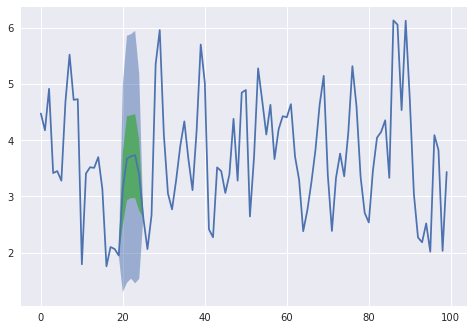

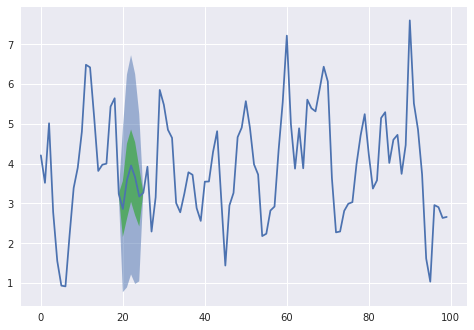

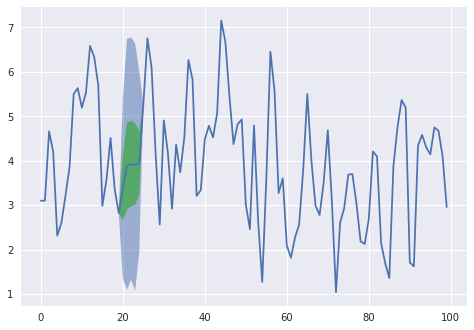

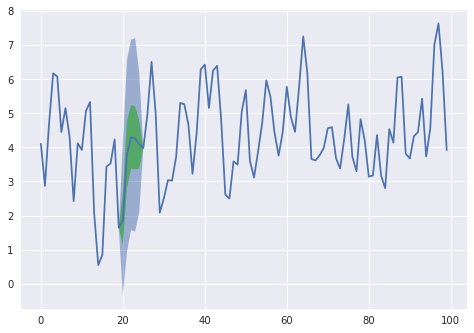

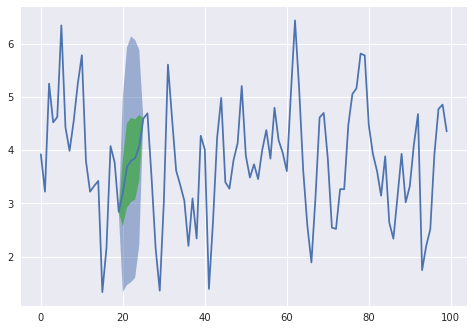

In [9]:
theta = array([.7, .1])
q = len(theta)

errs = (randn(t,n)*sigma)
Y = mu+errs
for i in range(1+q,t):
    Y[i] += dot(theta[::-1],errs[i-q:i])

Y[20:25] = nan


model = TimeSeriesModel(Y=Y, q=q)
start_time = time()
max_depth = 15
model.sampling(n_jobs=n_jobs, iter=4*n_iterations, control={'max_treedepth':max_depth})
finish_time = time()
print("Fitting took %.2f minutes"%((finish_time-start_time)/60))

parameter_pairs = [(mu, 'mu'), (sigma, 'sigma'), (theta, 'theta')]
test_model_fit(model.fit, parameter_pairs, max_depth=max_depth)

# print(model.fit)

for i in range(min(5,n)):
    figure()
    plot_time_series_inference(model.fit, ind=i)

Both autoregressive and moving average components
----
(An ARMA(2,2) model)

$\epsilon_t \sim normal(0, \sigma)$

$Y_t \sim \mu + \epsilon_t + \phi_1 Y_{t-1} + \phi_2 Y_{t-2} + \theta_1 \epsilon_{t-1} + \theta_2 \epsilon_{t-2}$

Priors:
- $\mu \sim normal(0,4)$
- $\sigma \sim cauchy(0,4)$
- $\phi \sim normal(0,4)$
- $\theta \sim normal(0,4)$

Fitting took 207.43 minutes
mu
"100% of values recovered"
"Maximum Rhat of 1.01"
sigma
"85% of values recovered"
"Maximum Rhat of 1.00"
phi
"98% of values recovered"
"Maximum Rhat of 1.01"
theta
"75% of values recovered"
"Maximum Rhat of 1.01"
"0 of 4000 iterations saturated the maximum tree depth of 15 (0.0%)"
"Chain 0: E-BFMI = 0.9293589238643611"
"Chain 1: E-BFMI = 0.8783179427372076"
"Chain 2: E-BFMI = 0.8401653799691775"
"Chain 3: E-BFMI = 0.9406746823218904"
"No divergences"


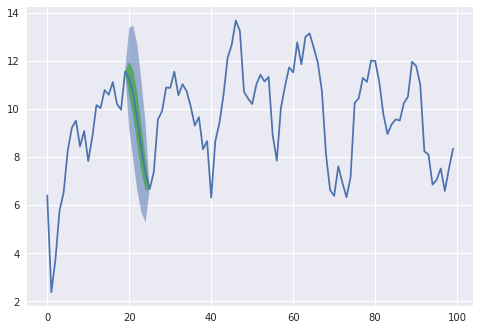

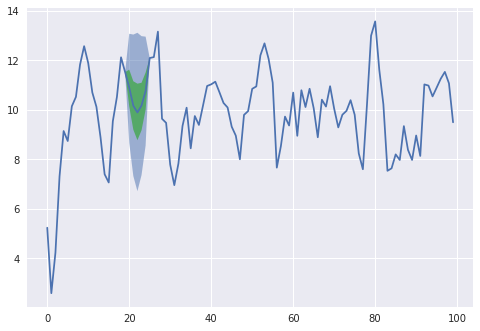

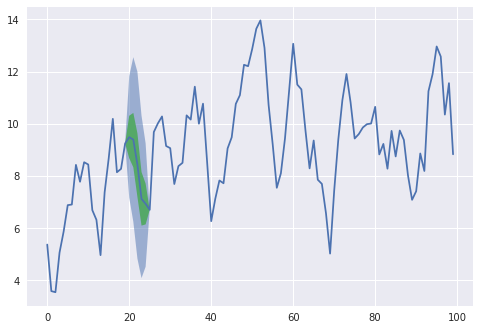

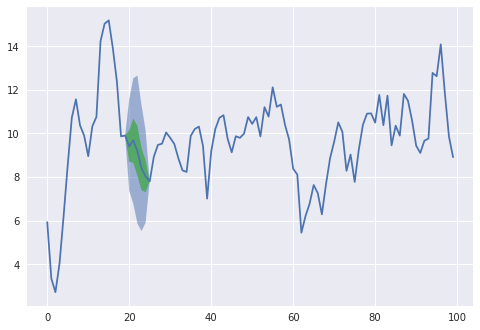

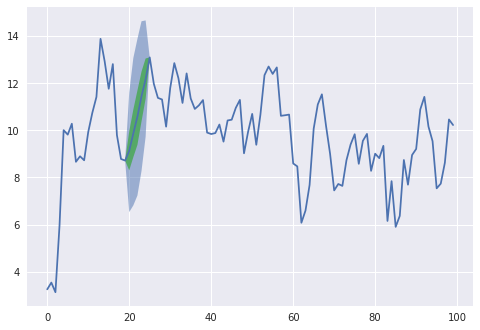

In [18]:
phi = array([.8, -.2])
p = len(phi)

theta = array([.4,.1])
q = len(theta)

errs = (randn(t,n)*sigma)
Y = mu+errs
for i in range(1+max(p,q),t):
    Y[i] += dot(phi[::-1],Y[i-p:i]) + dot(theta,errs[i-q:i])

Y[20:25] = nan

model = TimeSeriesModel(Y=Y, p=p, q=q)
start_time = time()
max_depth = 15
model.sampling(n_jobs=n_jobs, iter=4*n_iterations, control={'max_treedepth':max_depth})
finish_time = time()
print("Fitting took %.2f minutes"%((finish_time-start_time)/60))

parameter_pairs = [(mu, 'mu'), (sigma, 'sigma'), (phi, 'phi'), (theta, 'theta')]
test_model_fit(model.fit, parameter_pairs, max_depth=max_depth)

# print(model.fit)

for i in range(min(5,n)):
    figure()
    plot_time_series_inference(model.fit, ind=i)

Changes have normally distributed shocks, with a moving average component
---
(An IMA(1,1) model)

$\epsilon_t \sim normal(0, \sigma)$

$Y_t-Y_{t-1} \sim \mu + \epsilon_t + \theta \epsilon_{t-1}$

Priors:
- $\mu \sim normal(0,4)$
- $\sigma \sim cauchy(0,4)$
- $\theta \sim normal(0,4)$

Fitting took 0.99 minutes
mu
"95% of values recovered"
"Maximum Rhat of 1.00"
sigma
"90% of values recovered"
"Maximum Rhat of 1.00"
theta
"95% of values recovered"
"Maximum Rhat of 1.00"
"0 of 1000 iterations saturated the maximum tree depth of 10 (0.0%)"
"Chain 0: E-BFMI = 1.1302221750305148"
"Chain 1: E-BFMI = 0.9396923333252712"
"Chain 2: E-BFMI = 1.0757191797151002"
"Chain 3: E-BFMI = 1.009617297565081"
"No divergences"


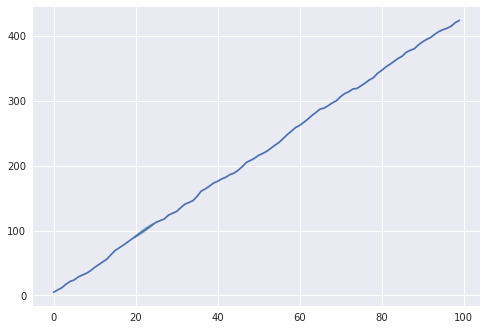

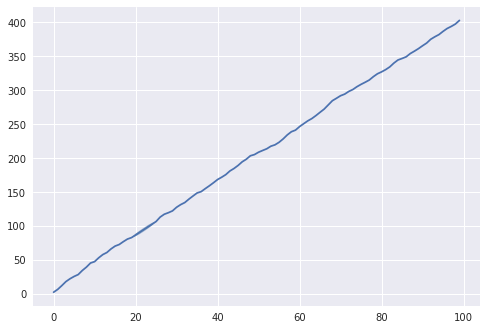

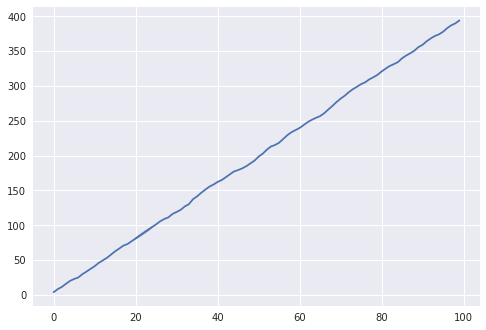

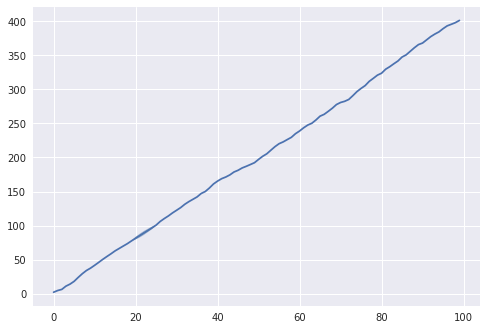

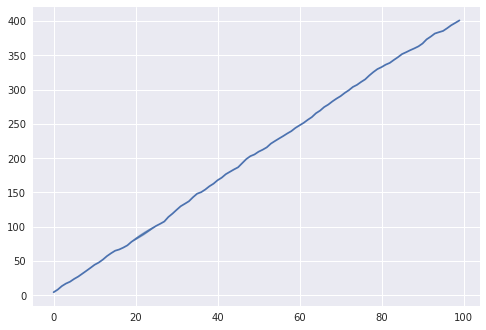

In [11]:
theta = array([.1])
q = len(theta)

errs = (randn(t,n)*sigma)
Y = mu+errs
for i in range(1+q,t):
    Y[i] += dot(theta[::-1],errs[i-q:i])
Y = cumsum(Y, axis=0)
    
Y[20:25] = nan

model = TimeSeriesModel(Y=Y, q=q, difference=[1])
start_time = time()
model.sampling(n_jobs=n_jobs, iter=n_iterations)
finish_time = time()
print("Fitting took %.2f minutes"%((finish_time-start_time)/60))

parameter_pairs = [(mu, 'mu'), (sigma, 'sigma'), (theta, 'theta')]
test_model_fit(model.fit, parameter_pairs)

# print(model.fit)

for i in range(min(5,n)):
    figure()
    plot_time_series_inference(model.fit, ind=i)

Require changes are positive
---
(A monotonically-increasing IMA(1,1) model)

$\epsilon_t \sim normal(0, \sigma)$

$Y_t-Y_{t-1} \sim \mu + \epsilon_t + \theta \epsilon_{t-1}$

$Y_t-Y_{t-1} > 0$

Priors:
- $\mu \sim normal(0,4)$
- $\sigma \sim cauchy(0,4)$
- $\theta \sim normal(0,4)$

Fitting took 0.72 minutes
mu
"95% of values recovered"
"Maximum Rhat of 1.00"
sigma
"90% of values recovered"
"Maximum Rhat of 1.00"
theta
"100% of values recovered"
"Maximum Rhat of 1.00"
"0 of 1000 iterations saturated the maximum tree depth of 10 (0.0%)"
"Chain 0: E-BFMI = 0.9045483398538862"
"Chain 1: E-BFMI = 0.9901300039946597"
"Chain 2: E-BFMI = 0.9581506680625631"
"Chain 3: E-BFMI = 0.7084528610320692"
"No divergences"


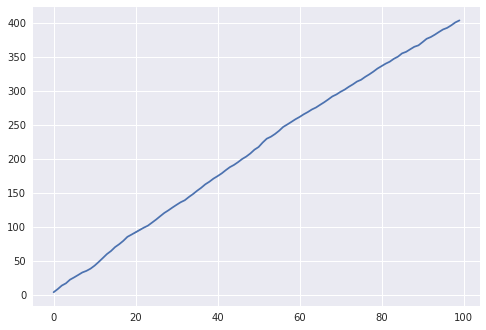

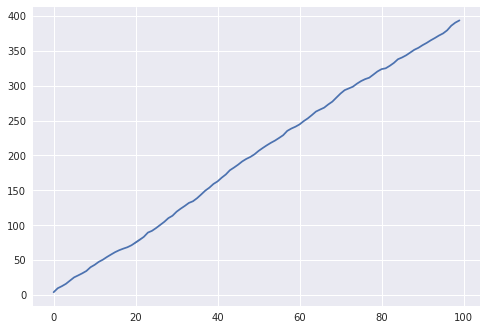

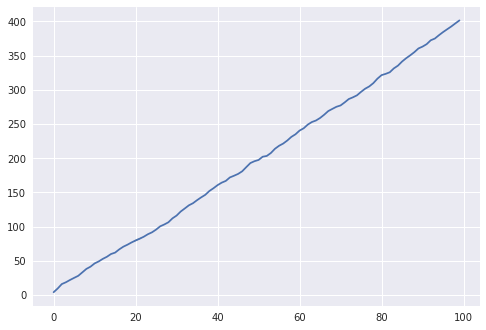

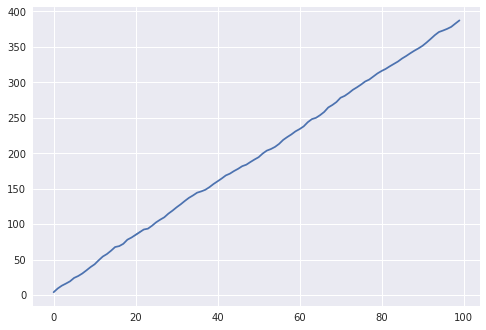

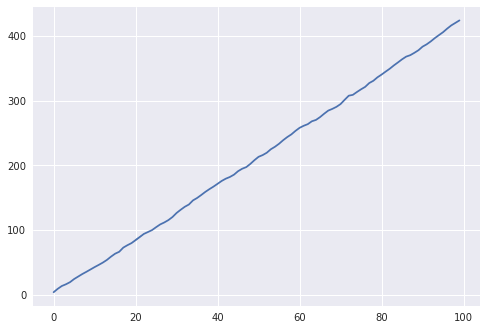

In [12]:
theta = array([.1])
q = len(theta)

from scipy.stats import truncnorm
Y = mu*ones((t,n))
errs = zeros((t,n))
for n_i in range(n):
    for t_i in range(1,q):
        expected_level = mu+Y[t_i-1,n_i]
        Y[t_i,n_i] = truncnorm(-Y[t_i-1,n_i], inf, expected_level, sigma).rvs()
        errs[t_i,n_i] = Y[t_i,n_i] - expected_level
    for t_i in range(q,t):
        expected_level = mu+dot(theta[::-1],errs[t_i-q:t_i,n_i])+Y[t_i-1,n_i]
        Y[t_i,n_i] = truncnorm(-Y[t_i-1,n_i], inf, expected_level, sigma).rvs()
        errs[t_i,n_i] = Y[t_i,n_i] - expected_level
        
Y[20:22] = nan

model = TimeSeriesModel(Y=Y, q=q, difference=[1], monotonic=[1])
start_time = time()
model.sampling(n_jobs=n_jobs, iter=n_iterations)
finish_time = time()
print("Fitting took %.2f minutes"%((finish_time-start_time)/60))

parameter_pairs = [(mu, 'mu'), (sigma, 'sigma'), (theta, 'theta')]
test_model_fit(model.fit, parameter_pairs)

# print(model.fit)

for i in range(min(5,n)):
    figure()
    plot_time_series_inference(model.fit, ind=i)

Make shocks t-distributed
---
(A IMA(1,1) model, but with t-distributed shocks)

$\epsilon_t \sim t(\nu, 0, \sigma)$

$Y_t-Y_{t-1} \sim \mu + \epsilon_t + \theta \epsilon_{t-1}$

Priors:
- $\mu \sim normal(0,4)$
- $\sigma \sim cauchy(0,4)$
- $\theta \sim normal(0,4)$
- $\nu \sim caucy(0,4)$

Fitting took 13.26 minutes
nu
"85% of values recovered"
"Maximum Rhat of 1.01"
mu
"95% of values recovered"
"Maximum Rhat of 1.00"
sigma
"95% of values recovered"
"Maximum Rhat of 1.01"
theta
"95% of values recovered"
"Maximum Rhat of 1.01"
"228 of 1000 iterations saturated the maximum tree depth of 10 (22.8%)"
"Run again with max_depth set to a larger value to avoid saturation"
"Chain 0: E-BFMI = 0.9413587965738353"
"Chain 1: E-BFMI = 0.8713629195537838"
"Chain 2: E-BFMI = 0.9398305659558757"
"Chain 3: E-BFMI = 0.8060180172418585"
"No divergences"


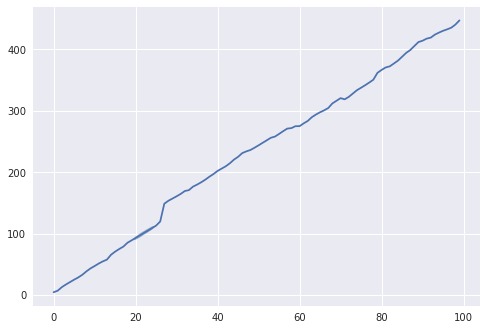

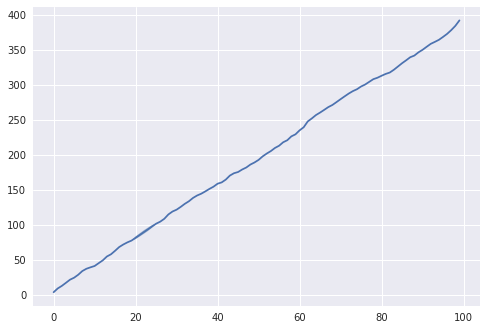

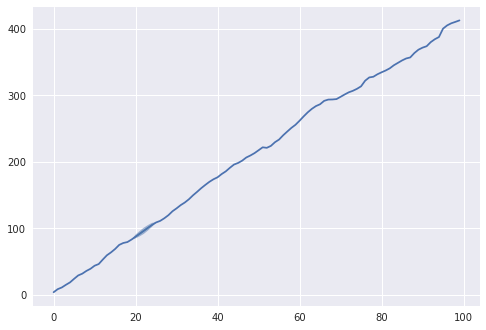

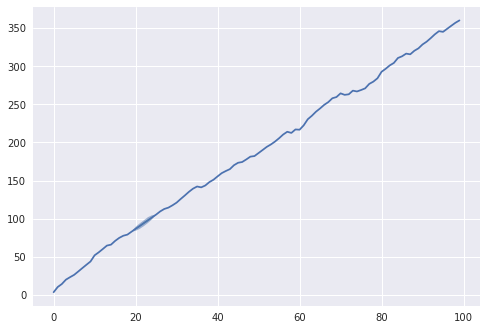

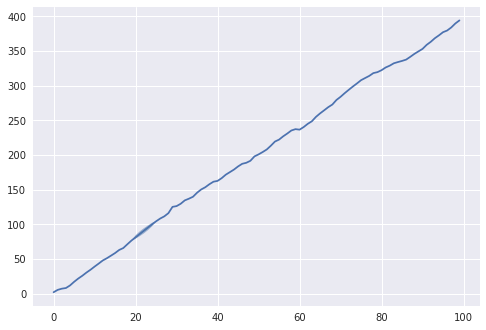

In [13]:
nu = 3

theta = array([.1])
q = len(theta)

errs = (standard_t(nu, (t,n))*sigma) 
Y = mu+errs
for i in range(1+q,t):
    Y[i] += dot(theta[::-1],errs[i-q:i])
Y = cumsum(Y, axis=0)
    
Y[20:25] = nan


model = TimeSeriesModel(Y=Y, q=q, difference=[1], use_student=True)
start_time = time()
model.sampling(n_jobs=n_jobs, iter=n_iterations)
finish_time = time()
print("Fitting took %.2f minutes"%((finish_time-start_time)/60))

parameter_pairs = [(nu, 'nu'), (mu, 'mu'), (sigma, 'sigma'), (theta, 'theta')]
test_model_fit(model.fit, parameter_pairs)

# print(model.fit)

for i in range(min(5,n)):
    figure()
    plot_time_series_inference(model.fit, ind=i)

Combine inference of time series' parameters by partially pooling
---
(An MA(1) model, with partial pooling of the estimation of $\mu$, $\sigma$ and $\theta$)

$Y_{i,t} \sim \mu_i + \epsilon_t + \theta_i \epsilon_{t-1}$

$\epsilon_t \sim \text{normal}(0, \sigma_i)$

$[\mu_i, \sigma_i, \theta_i] \sim [\hat{\mu}, \hat{\sigma}, \hat{\theta}] + \text{multinormal}(0,\text{diag}(\tau)*\Omega*\text{diag}(\tau))$


Priors:
- $\hat{\mu} \sim normal(0,4)$
- $\hat{\sigma} \sim cauchy(0,4)$
- $\hat{\theta} \sim normal(0,4)$
- $\tau \sim cauchy(0,1)$ (How much each parameter varies across the time series)
- $\Omega \sim LKJ(1)$ (How the parameters correlate with each other across the time series)

Fitting took 2.24 minutes
mu
"90% of values recovered"
"Maximum Rhat of 1.00"
sigma
"95% of values recovered"
"Maximum Rhat of 1.00"
theta
"95% of values recovered"
"Maximum Rhat of 1.00"
tau
"100% of values recovered"
"Maximum Rhat of 1.00"
"0 of 1000 iterations saturated the maximum tree depth of 10 (0.0%)"
"Chain 0: E-BFMI = 1.0215920948153372"
"Chain 1: E-BFMI = 0.7446498123265233"
"Chain 2: E-BFMI = 1.045446204279558"
"Chain 3: E-BFMI = 1.0449037260021468"
"No divergences"


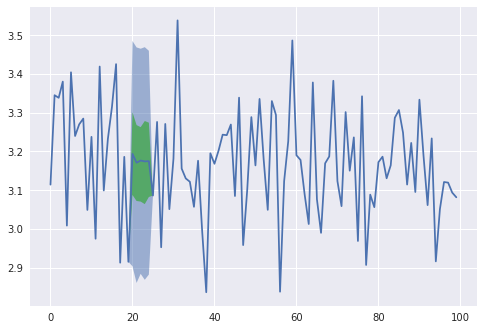

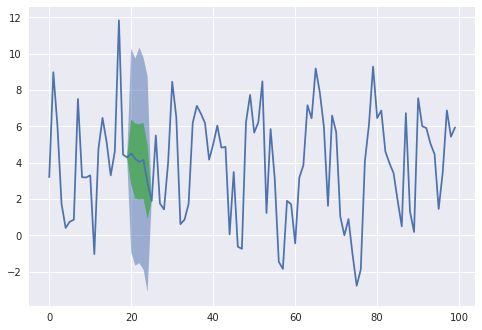

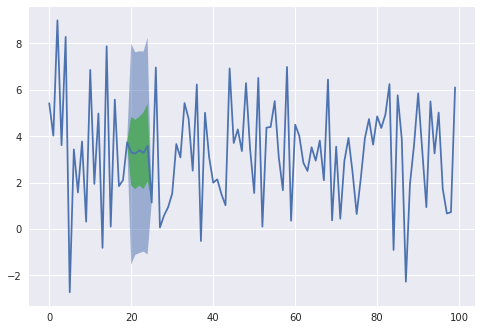

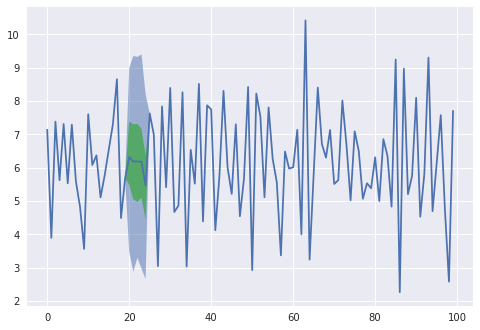

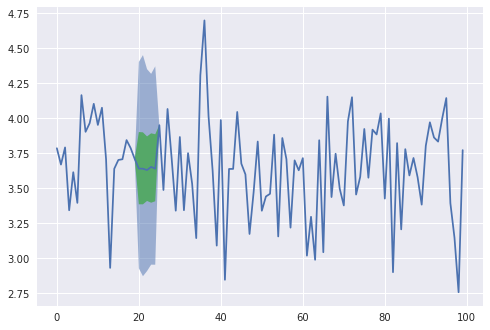

In [14]:
mu_hat = 4
sigma_hat = 1
theta_hat = .1

Omega = matrix([[1,.5,0,],
               [.5,1,0,],
               [0,0,1,]])
tau = array([1,1,1])
cov = diag(tau)*Omega*diag(tau)

from scipy.special import logit, expit

parameters = multivariate_normal(array([mu_hat, 
                                       log(sigma_hat), 
                                       logit((theta_hat+1)/2)]),
                                        cov=cov,
                                        size=n)
mu = parameters[:,0]
sigma = exp(parameters[:,1])
theta = expit(parameters[:,2])*2-1
q = 1
Y = zeros((t,n))
for n_ind in arange(n):    
    errs = randn(t)*sigma[n_ind]
    Y[:,n_ind] = mu[n_ind]+errs
    for i in range(1+q,t):
        Y[i,n_ind] += (theta[n_ind]*errs[i-q:i])

    
Y[20:25] = nan


model = TimeSeriesModel(Y=Y, q=q, use_partial_pooling=True)
start_time = time()
model.sampling(n_jobs=n_jobs, iter=n_iterations)
finish_time = time()
print("Fitting took %.2f minutes"%((finish_time-start_time)/60))

parameter_pairs = [(mu, 'mu'), (sigma, 'sigma'), (theta, 'theta'), (tau, 'tau')]
test_model_fit(model.fit, parameter_pairs)

# print(model.fit)

for i in range(min(5,n)):
    figure()
    plot_time_series_inference(model.fit, ind=i)

Time series is multi-dimensional, and the different dimensions can influence each other
---
(A VAR model, with a MA(1) component)


$\vec{Y}_{t} = [Y_{1,t}, Y_{2,t}, Y_{3,t}...Y_{D,t}]$ 

$\vec{Y}_{t} \sim \vec{\mu} + \vec{\epsilon}_{t} + \vec{\theta} \vec{\epsilon}_{t-1} + \mathbf{P}\vec{Y}_{t-1}$

$\vec{\epsilon}_t \sim \text{normal}(0, \vec{\sigma})$


where $\mathbf{P}$ is a $D x D$ matrix


Priors (for each element in the vector or matrix):
- $\vec{\mu} \sim normal(0,4)$
- $\vec{\sigma} \sim cauchy(0,4)$
- $\mathbf{P} \sim normal(0,4)$
- $\vec{\theta} \sim normal(0,4)$

Fitting took 13.15 minutes
mu
"98% of values recovered"
"Maximum Rhat of 1.00"
sigma
"77% of values recovered"
"Maximum Rhat of 1.00"
phi
"100% of values recovered"
"Maximum Rhat of 1.00"
theta
"100% of values recovered"
"Maximum Rhat of 1.01"
"0 of 4000 iterations saturated the maximum tree depth of 10 (0.0%)"
"Chain 0: E-BFMI = 0.904867664839767"
"Chain 1: E-BFMI = 0.9633733141341112"
"Chain 2: E-BFMI = 1.0170028788815813"
"Chain 3: E-BFMI = 0.9495694999449725"
"No divergences"


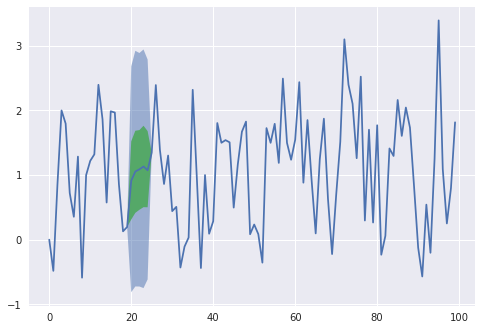

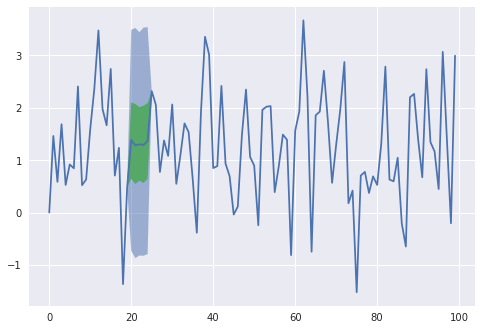

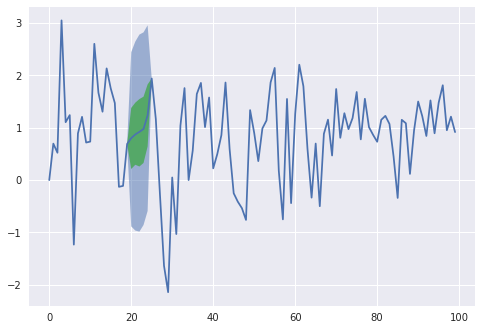

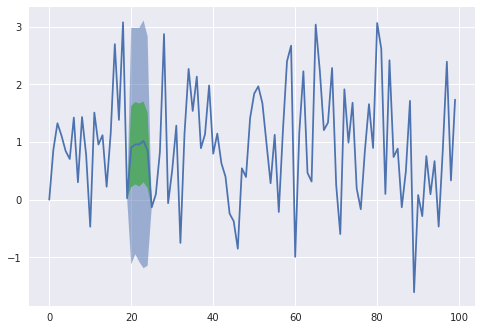

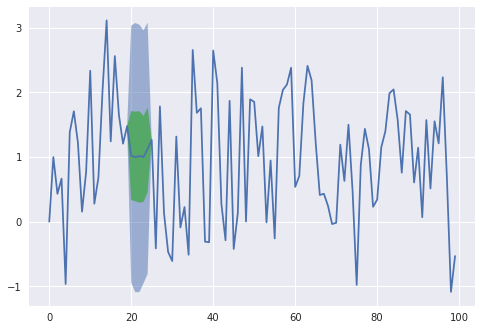

In [15]:
D = 3

mu = rand(D)
sigma = rand(D)

p = 1
phi = .1*rand(p,D,D)

theta = array([.2])
q = len(theta)

Y = zeros((n,t,D))
errs = (randn(n,t,D)*sigma)
for n_i in range(n):
    for t_i in range(max(q,p),t):
        Y[n_i,t_i] += mu+dot(theta[::-1],errs[n_i,t_i-q:t_i])+errs[n_i,t_i]
        for p_i in range(p):
            Y[n_i,t_i] +=  dot(phi[p_i],Y[n_i,t_i-p_i])

Y[:,20:25] = nan

model = TimeSeriesModel(Y=Y, p=p, q=q)
start_time = time()
model.sampling(n_jobs=n_jobs, iter=2000)#n_iterations)
finish_time = time()
print("Fitting took %.2f minutes"%((finish_time-start_time)/60))

parameter_pairs = [(mu, 'mu'), (sigma, 'sigma'), (phi, 'phi'), (theta, 'theta')]
test_model_fit(model.fit, parameter_pairs)

# print(model.fit)

for i in range(min(5,n)):
    figure()
    plot_time_series_inference(model.fit, ind=i)